In [2]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.style.use('ggplot')

import requests
import json
from ast import literal_eval
import gc

In [3]:
# read the csv of all talk posts (panoptes and ouroboros)
talk_df = pd.read_csv('/srv/zooniverse/tables/all_talk_table_06-13-17.csv')
talk_df['created_at'] = pd.to_datetime(talk_df['created_at'])

/home/sjm668/dev/zooniverse/src/venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,4,6,9,12,15,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# read the csv of all classifications (panoptes and ouroboros)
classification_df = pd.read_csv('/srv/zooniverse/tables/all_classifications_table_05-31-17.csv')
classification_df['created_at'] = pd.to_datetime(classification_df['created_at'])

/home/sjm668/dev/zooniverse/src/venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# read the csv of project metadata
project_df = pd.read_csv('/srv/zooniverse/tables/all_projects_table_05-31-17.csv')

In [6]:
# number of projects with dump, api, and talk, and offical
project_overlap = len(project_df.loc[(project_df['panoptes_api'] == 1) & (project_df['talk'] == 1) & ((project_df['ouroboros_dump'] == 1) | (project_df['panoptes_api'] == 1)) & (project_df['panoptes_api_official_project'] == 1)])
print('projects with dump, api, and talk, and offical flag: {0}'.format(project_overlap))

projects with dump, api, and talk, and offical flag: 53


In [7]:
complete_projects = project_df.loc[(project_df['panoptes_api'] == 1) & (project_df['talk'] == 1) & ((project_df['ouroboros_dump'] == 1) | (project_df['panoptes_api'] == 1)) & (project_df['panoptes_api_official_project'] == 1)]
complete_classifications = classification_df.loc[classification_df['panoptes_project_id'].isin(complete_projects['panoptes_project_id'])]
complete_talk = talk_df[talk_df['panoptes_project_id'].isin(complete_projects['panoptes_project_id'])]

In [8]:
print('number of official projects with talk and classification data: {0}'.format(len(complete_projects['panoptes_project_id'].unique())))
print('number of classifications from official projects with talk and classification data: {0}'.format(len(complete_classifications)))
print('number of talk posts from official projects with talk and classification data: {0}'.format(len(complete_talk)))

number of official projects with talk and classification data: 53
number of classifications from official projects with talk and classification data: 75824006
number of talk posts from official projects with talk and classification data: 1832615


In [9]:
classifications_per_project = complete_classifications.groupby('panoptes_project_id')['panoptes_project_id'].count().to_frame('classifications').reset_index()

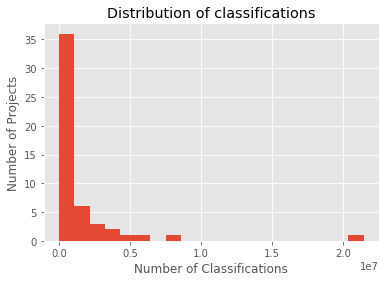

In [10]:
classifications_per_project['classifications'].hist(bins=20)
plt.title('Distribution of classifications')
plt.xlabel('Number of Classifications')
plt.ylabel('Number of Projects')

In [11]:
print('Classifications per Project')
classifications_per_project['classifications'].describe(percentiles=np.arange(0,1,0.1))

Classifications per Project


count    5.100000e+01
mean     1.486745e+06
std      3.278789e+06
min      1.070000e+02
0%       1.070000e+02
10%      2.916800e+04
20%      7.887800e+04
30.0%    1.300800e+05
40%      2.043130e+05
50%      5.030040e+05
60.0%    7.046780e+05
70%      9.646390e+05
80%      1.828034e+06
90%      4.181735e+06
max      2.141911e+07
Name: classifications, dtype: float64

In [12]:
talk_per_project = complete_talk.groupby('panoptes_project_id')['panoptes_project_id'].count().to_frame('comments').reset_index()

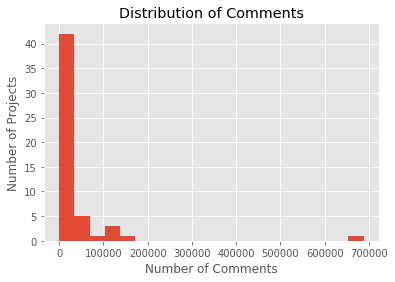

In [13]:
talk_per_project['comments'].hist(bins=20)
plt.title('Distribution of Comments')
plt.xlabel('Number of Comments')
plt.ylabel('Number of Projects')

In [14]:
print('Comments per Project')
talk_per_project['comments'].describe(percentiles=np.arange(0,1,0.1))

Comments per Project


count        53.000000
mean      34577.641509
std       98830.882923
min          57.000000
0%           57.000000
10%         378.200000
20%         846.000000
30.0%      1292.000000
40%        2546.400000
50%        5270.000000
60.0%     12729.600000
70%       16495.000000
80%       36001.600000
90%       87603.600000
max      687563.000000
Name: comments, dtype: float64

In [15]:
# talk outlier
complete_projects.loc[complete_projects['panoptes_project_id'].isin(talk_per_project.loc[talk_per_project['comments'] == talk_per_project['comments'].max()].reset_index()['panoptes_project_id'])][['ouroboros_project_name','panoptes_project_id']]

,ouroboros_project_name,panoptes_project_id
5,Planet Hunters,26.0


In [16]:
# classification outlier
complete_projects.loc[complete_projects['panoptes_project_id'].isin(classifications_per_project.loc[classifications_per_project['classifications'] == classifications_per_project['classifications'].max()].reset_index()['panoptes_project_id'])][['ouroboros_project_name','panoptes_project_id']]

,ouroboros_project_name,panoptes_project_id
27,Snapshot Serengeti,40.0


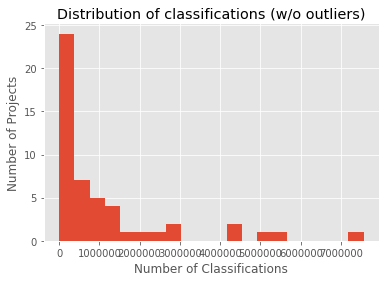

In [17]:
classifications_per_project.loc[classifications_per_project['panoptes_project_id'] != 40]['classifications'].hist(bins=20)
plt.title('Distribution of classifications (w/o outliers)')
plt.xlabel('Number of Classifications')
plt.ylabel('Number of Projects')

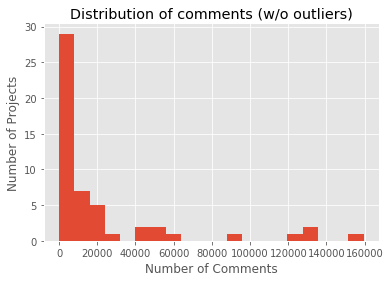

In [18]:
talk_per_project.loc[talk_per_project['panoptes_project_id'] != 26]['comments'].hist(bins=20)
plt.title('Distribution of comments (w/o outliers)')
plt.xlabel('Number of Comments')
plt.ylabel('Number of Projects')

In [19]:
first_row = complete_classifications.groupby('panoptes_project_id')['created_at'].transform(min)
complete_classifications['age_weeks'] = complete_classifications['created_at'].subtract(first_row,axis='index').astype('timedelta64[D]').floordiv(7)

/home/sjm668/dev/zooniverse/src/venv/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [24]:
complete_classifications.groupby(['panoptes_project_id','age_weeks'])['age_weeks'].count().unstack(level=0).max().max()

3457552.0

In [28]:
complete_classifications.groupby(['panoptes_project_id','age_weeks'])['age_weeks'].count().unstack(level=0).max().to_frame('classifications').reset_index().merge(project_df[['panoptes_project_id','panoptes_project_name']],on='panoptes_project_id')

,panoptes_project_id,classifications,panoptes_project_name
0,11.0,21888.0,Whales as Individuals
1,14.0,130857.0,Snapshots at Sea
2,17.0,39331.0,Planet Four: Terrains
3,26.0,764871.0,Planet Hunters
4,36.0,57250.0,Cyclone Center
5,40.0,3457552.0,Snapshot Serengeti
6,41.0,2791676.0,Planet Four
7,45.0,135385.0,Worm Watch Lab
8,46.0,95564.0,Plankton Portal
9,47.0,139653.0,Radio Galaxy Zoo


In [26]:
complete_projects.loc[complete_projects['panoptes_project_id'] == 41][['ouroboros_project_name','panoptes_project_id']]

,ouroboros_project_name,panoptes_project_id
28,Planet Four,41.0


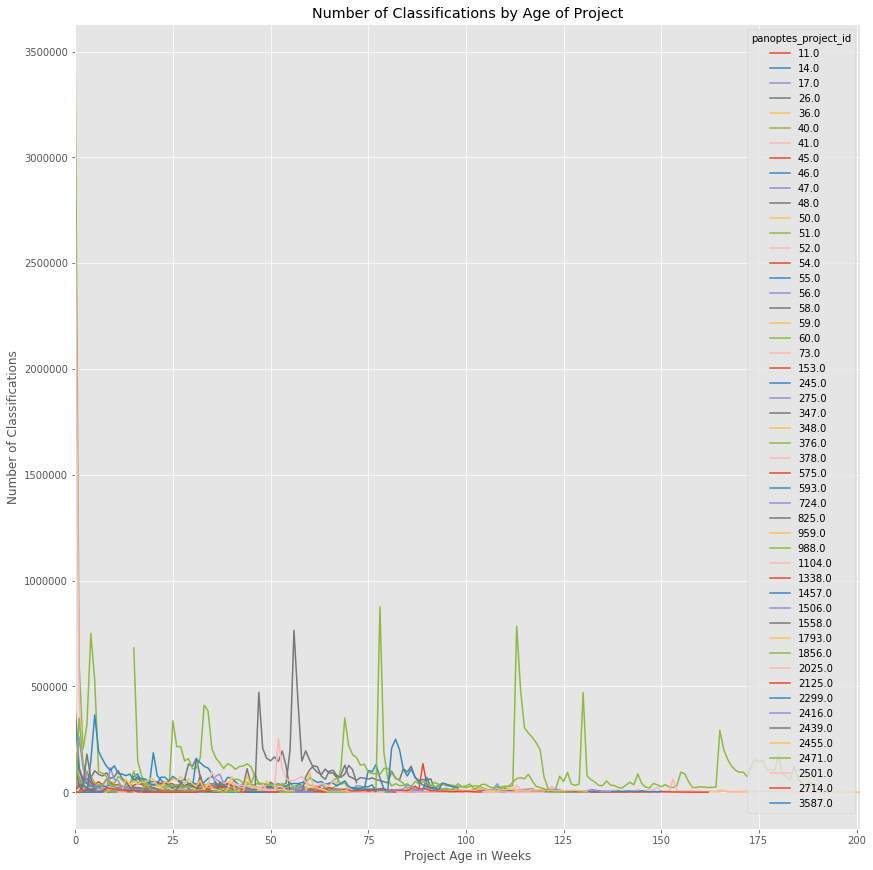

In [35]:
classifications_by_week = complete_classifications.groupby(['panoptes_project_id','age_weeks'])['age_weeks'].count().unstack(level=0)
classifications_by_week.plot(figsize=(12,12))
plt.tight_layout()
plt.ylabel('Number of Classifications')
plt.xlabel('Project Age in Weeks')
plt.title('Number of Classifications by Age of Project')

In [27]:
project_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'panoptes_api_classificaitons_count',
       'panoptes_api_official_project', 'panoptes_api_roles',
       'panoptes_api_subject_count', 'panoptes_api_workflows',
       'panoptes_completeness', 'panoptes_description', 'panoptes_launch_date',
       'panoptes_live', 'panoptes_migrated', 'panoptes_project_id',
       'panoptes_project_name', 'panoptes_api',
       'panoptes_dump_classification_count', 'panoptes_dump_workflows',
       'panoptes_dump', 'ouroboros_mongo_id',
       'ouroboros_meta_activated_subjects_at',
       'ouroboros_meta_classification_count', 'ouroboros_meta_complete_count',
       'ouroboros_meta_created_at', 'ouroboros_project_name',
       'ouroboros_meta_user_count', 'ouroboros_dump', 'talk'],
      dtype='object')